In [1]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
%matplotlib inline


## Neural Networks
Let us review the analysis of the standard multiple linear regression model
with Gaussian noise

$$
f(x) = x^T w, ~~~~~y = f(x)+ v, ~~~~~v \sim N(0,\sigma^2)
$$

where $x \in \mathbb{R}^m$ is the input vector (we have $m$ input variables), $w\in \mathbb{R}^m$ is the vector of parameters (weights, we usually call it $\beta$) of the linear
model, $f$ is the regression function  and $y$ is the output variable. 

Usually  a bias weight or offset is included $f(x) = x^T w  +w_0$, but as this can be implemented by augmenting the input vector $x$ with an additional element whose value is always one, we do not explicitly include it in our notation.

The assumption of linearity is very restrictive.

A very simple idea to overcome this problem is to
first project the inputs $x$ into some high dimensional space using a set of basis
functions and then apply the linear model in this space instead of directly on
the inputs themselves. 

For example, a scalar input $x$ could be projected into
the space of powers: 

$$
\phi(x) = (1, x, x^2 , x^3, \dots, x^{d}) 
$$
obtaining polynomial regression.

Another example: $x$ is a scalar input, we project it  into
the space of functions of $x$: 

$$
\phi(x) = \tanh([1,x] W^{(1)}) 
$$

where $W^{(1)} \in \mathbb{R}^{2 \times d}$ is a matrix 
of parameters, obtaining a Neural Network (Multilayer perceptron).

## Polynomial regression
$$
\phi(x) = (1, x, x^2 , x^3, \dots, x^{d}) 
$$

and, therefore,

$$
\begin{aligned}
f(x)&=\phi(x)^T w^{(2)} = \sum\limits_{i=0}^{d} w_i^{(2)} x^{i} \\
&=w_0^{(2)}+w_1^{(2)}x+w_2^{(2)} x^2+\dots+w_{d}^{(2)}x^{d}
\end{aligned}
$$

This is our polynomial regression function with unknown parameters 
$w_i^{(2)}$.

I use $^{(2)}$ to denote an index (not power). This notation will become convenient when we will consider NN. In this case $^{(2)}$ denotes the last layer of a Deep NN (the linear layer).

## NN
Let's focus on

$$
\phi(x) = \tanh([1,x] W^{(1)}) 
$$

Let's write the elements of $W^{(1)}$: 

$$
W^{(1)}=\begin{bmatrix}
w_{11}^{(1)} & w_{21}^{(1)} & \cdots & w_{d 1}^{(1)}\\
w_{12}^{(1)} & w_{22}^{(1)} & \cdots & w_{d 2}^{(1)}\\
\end{bmatrix}
 $$

and, therefore, the number of columns corresponds to the number of hidden-units:

$$
\phi(x) = [\tanh(w_{11}^{(1)}+w_{12}^{(1)}x),\tanh(w_{21}^{(1)}+w_{22}^{(1)}x),\dots,\tanh(w_{d1}^{(1)}+w_{d2}^{(1)}x) ]^T
$$

and

$$
f(x,\theta)=\phi(x)^T w^{(2)} =\sum\limits_{i=1}^{d} w_i^{(2)} \tanh(w_{i1}^{(1)}+w_{i2}^{(1)}x)
$$

where $\theta$ denotes the vector of parameters $(\hat{w}^{(2)},{W}^{(1)})$

## Fitting the unknow weights

We have defined a model

$$
y=f(x,\theta)
$$

that takes as input $x$ and  outputs $y$, with $\theta$ denoting
its parameters $(\hat{w}^{(2)},{W}^{(1)})$.

**Training phase**, it uses the data $data=\{(x_i,y_i):~i=1,\dots,N\}$,
to find the value of the parameters $\theta$ that minimises the loss function:

$$
\hat{\theta}:=\arg\min_{\theta}   \sum_{i=1}^N L(y_i,f(x_i,\theta))
$$

where $L(\cdot,\cdot)$ is called loss function.

**Test phase** (prediction):
$$
\hat{y}=f(x_{pred},\hat{\theta})
$$

This is a general formulation: it holds for linear regression but also for neural networks,
and any other standard ML algorithm.

Let'see it with an example.

## Data generation
Here we generate some data from a nonlinear function. I am using a Gaussian Process to sample a nonlinear function, but don't worry about that.

Text(0.5, 1.0, 'test set')

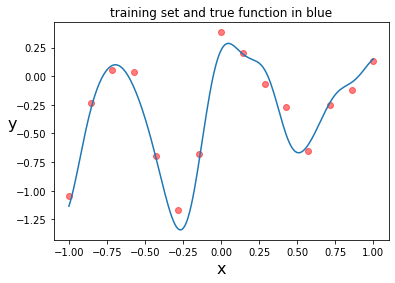

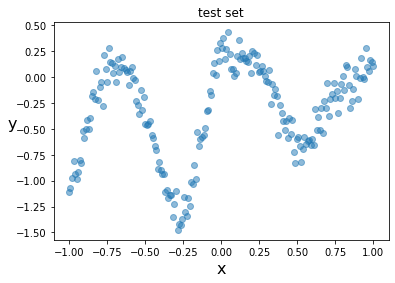

In [6]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
n=15
x  = np.linspace(-1,1,n) # n points evenly spaced over [0,1]
xtest = np.linspace(-1,1,200)
x1 = np.hstack([x,xtest]).reshape(-1,1)
# reshape X to make it n*D
mu = np.zeros((len(x1)))# vector of the means
C = k.K(x1,x1)# covariance matrix
# Generate 20 sample path with mean mu and covariance C
np.random.seed(1)
Z= np.random.multivariate_normal(mu,C,1)[0,:]
#training noisy data
y  = Z[0:len(x)]+np.random.randn(len(x))*0.1
#test noisy data
ytest = Z[len(x):]+np.random.randn(len(xtest))*0.1
#tru function
Z = Z[len(x):]
# plotting
pb.figure()
pb.plot(xtest,Z,zorder=100)
pb.scatter(x,y,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("training set and true function in blue")
#pb.savefig("data_1.pdf");
pb.figure()
pb.scatter(xtest,ytest,alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("test set")
#pb.savefig("test_set.pdf");

## Fitting a NN using MLE
This is what Keras does. Keras minimises a loss function (the MSE), which is equivalent to maximizing MLE.

We have the usual over-fitting problem for MLE based estimate. At the increase of the hidden-units and so of the parameters of the network, the NN starts overfitting!

Using TensorFlow backend.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 /home/benavoli/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wil

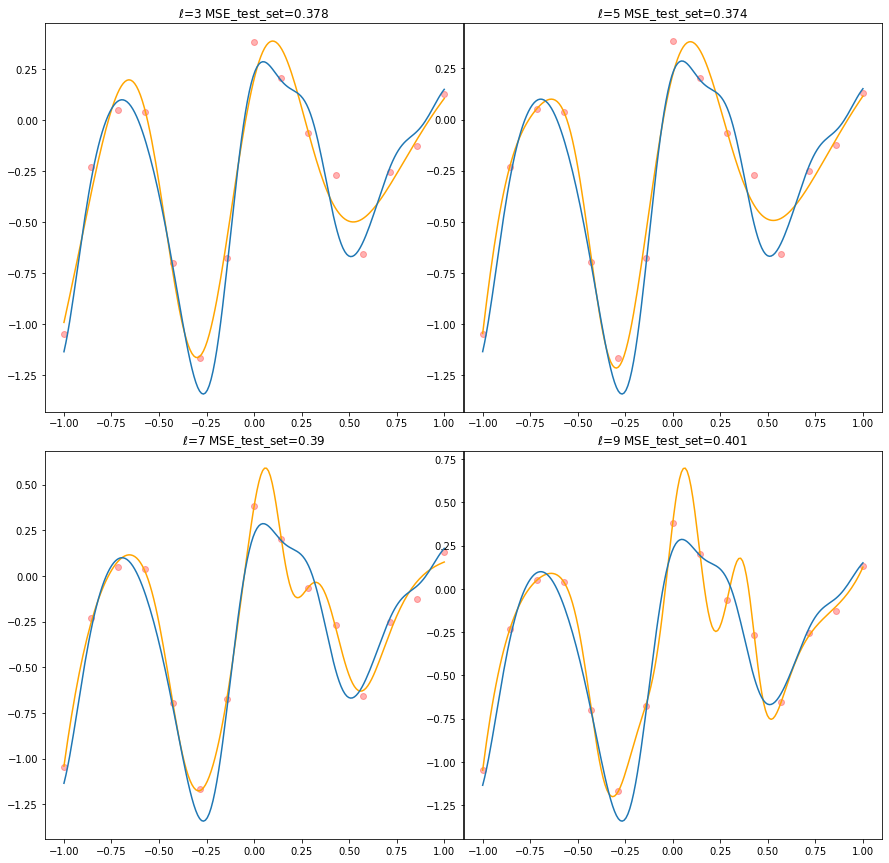

In [7]:
from keras.models import Sequential
from keras.layers import Dense

fig, axs = pb.subplots(2,2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

axs = axs.ravel()
d=0
#loop on the number of hidden units
for l in range(3,10,2):   
    # fix random seed for reproducibility
    seed = 7
    np.random.seed(seed)
    # create model
    model = Sequential()
    #inner layer
    model.add(Dense(l, input_dim=1, kernel_initializer='normal', activation='tanh', name='input_layer'))
    #outer linear layer
    model.add(Dense(1,  kernel_initializer='normal', activation='linear', name='output_layer'))
    # Compile model
    model.compile(loss='mse',  optimizer='adam')
    #fit model
    history = model.fit(x, y,  epochs=25000, batch_size=200, verbose=0)
    #plot
    y_pred=model.predict(xtest)
    axs[d].plot(xtest,Z,zorder=100,label='true')
    axs[d].plot(xtest,y_pred,c='orange',label='NN')
    axs[d].scatter(x,y,c='r',alpha=0.3)
    axs[d].set_title('$\ell$='+str(l)+' MSE_test_set='+str(np.round(np.mean((y_pred-ytest)**2),3)))
    d=d+1
#pb.savefig("NN_overfitting.pdf",  bbox_inches='tight')
#    return 

In the last plot, you can see the typical example of overfitting. The function fits the data perfectly. Of course, it has also the maximum error
in the test-set

## Bayesian NN
It is straightforward to write down the probabilistic model for a NN:

Ingredient 1:

$$
y=\sum\limits_{i=1}^{\ell} {\color{blue} w^{(2)}_i} \tanh({\color{blue}w_{i1}^{(1)}}+{\color{blue}w_{i2}^{(1)}}x),
$$
$\mathcal{H}=\{w_{ij}^{(1)},w_{ij}^{(2)} \in \mathbb{R}\}$.

Ingredient 2: prior hypothesis space, we place a prior on the weights

$$
p(h)=p(w_{ij}^{(k)})~~~\Big(=N(w_{ij}^{(k)},0,10)\Big)
$$

Ingredient 3: the likelihood (assuming Gaussian noise)

$$
\begin{aligned}
p(\text{data}|h)&=\prod_{i=1}^n N\left(y_i;\sum\limits_{i=1}^{\ell} {\color{blue} w^{(2)}_i} \tanh({\color{blue}w_{i1}^{(1)}}+{\color{blue}w_{i2}^{(1)}}x),\sigma\right)
\end{aligned}
$$

Basiccaly it is the same model of linear regression, but the function we use for regression is nonlinear (a NN).

Let's implement it in PyMC3 and compute the posterior.

In [16]:
import theano

# we add a column of ones because we want to include an intercept in our model
x1 = np.vstack([np.ones(len(x)),x]).T
floatX = theano.config.floatX

l = 9 #number of hidden nodes

# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

with pm.Model() as neural_network:
    #we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', y)
    #Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=10,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2', 0, sigma=10,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    #Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer (like in Linear regression)
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    #standard deviation of noise
    sigma = pm.Gamma('sigma',1,1)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)
    

#we can do instead an approximated inference
with neural_network:
    inference = pm.SVGD()
    approx = pm.fit(40000, method=inference, obj_optimizer=pm.adam())

100%|██████████| 40000/40000 [02:13<00:00, 298.79it/s]


ADVI is not able to cope with posterior with multiple modes; we can instead use SVGD, which generates a better approximation. We compute the prediction for each sample. Note that we use `np.tanh` instead of `pm.math.tanh`
for speed reason. `pm.math.tanh` is slower outside a Pymc3 model because it converts all data in theano format, that is convenient to do GPU-based training but it is slow when we only need to compute predictions.

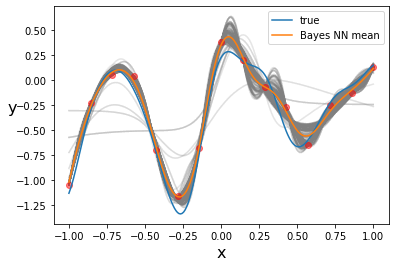

In [17]:
posterior = approx.sample(draws=7000)
    
x1 = np.vstack([np.ones(len(xtest)),xtest]).T
ypred=[]
for i in range(posterior['w_1'].shape[0]):#MC posterior['w_1'].shape[0]
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x1.T))
    #outer layer
    ypred.append(np.dot(posterior['w_2'][i,:],t1))
ypred = np.array(ypred)

#y_es=posterior['act_out'].mean(axis=0)
pb.plot(xtest,Z,label='true',Zorder=100)
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean',Zorder=100)
for i in range(700):
    pb.plot(xtest,ypred[i,:],c='gray',alpha=0.05)
pb.scatter(x,y,c='r',alpha=0.5,Zorder=100)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
#pb.ylim([-1,1.5])
pb.legend()
#pb.savefig("BayesNN_l9.pdf")

You can notice that Bayesian NN does not overfit, the posterior mean is quite reasonable.
This shows the advantage of representing uncertainty: the solution returned by Keras (MLE) is only one of the possible posterior lines compatible with the data. When we average all alternative hypotheses, we take into account of the uncertainty. This explains why computing the posterior mean is always better than returning MLE or MAP.

## We now generate more data

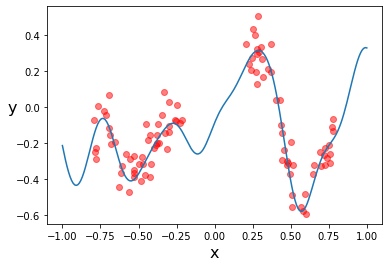

In [20]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
np.random.seed(40)
n=100
x  = np.sort(np.hstack([np.random.rand(int(n/2))*0.6-0.8,np.random.rand(int(n/2))*0.6+0.2])) # 500 points evenly spaced over [0,1]
xtest = np.linspace(-1,1,200)
x1 = np.hstack([x,xtest]).reshape(-1,1)
# reshape X to make it n*D
mu = np.zeros((len(x1)))# vector of the means
C = k.K(x1,x1)# covariance matrix
# Generate 20 sample path with mean mu and covariance C

Z= np.random.multivariate_normal(mu,C,1)[0,:]
y  = Z[0:len(x)]+np.random.randn(len(x))*0.1
ytest = Z[len(x):]+np.random.randn(len(xtest))*0.1
Z = Z[len(x):]
pb.figure()# 
pb.plot(xtest,Z,zorder=100)
pb.scatter(x,y,c='r',alpha=0.5)#training data
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0);
#pb.savefig("data.pdf");


In this example, we  first generate a nonlinear functions and then generate noisy training data from this function, but we constrained  the inputs $x$ to belong either to interval $[-0.8,-0.2]$ or  $[0.2,0.8]$.
That means that there is not data in $[-0.2,0.2]$. Our goal is to evaluate the extrapolation error outside $[-0.8,-0.2]$ or  $[0.2,0.8]$

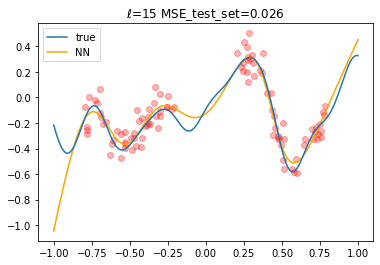

In [22]:
from keras.models import Sequential
from keras.layers import Dense

seed = 7
np.random.seed(seed)
# create model
l=15
model = Sequential()
model.add(Dense(l, input_dim=1, kernel_initializer='normal', activation='tanh', name='input_layer'))
model.add(Dense(1,  kernel_initializer='normal', activation='linear', name='output_layer'))
# Compile model
model.compile(loss='mse',  optimizer='adam')
#fit model
history = model.fit(x, y,  epochs=25000, batch_size=200, verbose=0)
#plot
y_pred=model.predict(xtest)
pb.plot(xtest,Z,zorder=100,label='true')
pb.plot(xtest,y_pred,c='orange',label='NN')
pb.scatter(x,y,c='r',alpha=0.3)
pb.title('$\ell$='+str(l)+' MSE_test_set='+str(np.round(np.mean((y_pred[:,0]-ytest)**2),3)))
pb.legend()
#pb.savefig("NN_gap.pdf",  bbox_inches='tight')
#    return 

Note that **standard ML does not tell us anything about the uncertainty. For instance,  the estimate
in $[-0.2,0.2]$ should be less reliable than that in $[-0.8,-0.2]$ because there is no data in  $[-0.2,0.2]$.
However, Keras only returns the prediction, there is no uncertainty.**

This together with the overfitting problems shows once again that general-recipe ML is not a sound approach.


Now we address the previous nonlinear regression problem by using a Bayesian NN.


In [24]:
import theano
# we add a column of ones because we want to include an intercept in our model
x1 = np.vstack([np.ones(len(x)),x]).T
floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

with pm.Model() as neural_network:
    #we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', y)
    #Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=10,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2', 0, sigma=10,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    #Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer (like in Linear regression)
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    #standard deviation of noise
    sigma = pm.Gamma('sigma',1,1)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)
    


We can sample some regression lines from the prior as follows.

We now compute the posterior.

In [25]:

#we can do instead an approximated inference
with neural_network:
    inference = pm.SVGD()
    approx = pm.fit(80000, method=inference, obj_optimizer=pm.adam())

100%|██████████| 80000/80000 [09:20<00:00, 142.79it/s]


 We then sample from the approximated posterior

In [26]:
posterior = approx.sample(draws=7000)

In [28]:
x1 = np.vstack([np.ones(len(xtest)),xtest]).T
ypred=[]
for i in range(posterior['w_1'].shape[0]):#MC posterior['w_1'].shape[0]
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x1.T))
    #outer layer
    ypred.append(np.dot(posterior['w_2'][i,:],t1))
ypred = np.array(ypred)

In [29]:
ypred

array([[-1.70897924, -1.68163822, -1.65007927, ...,  0.49292313,
         0.53290426,  0.57332264],
       [-2.34799083, -2.26532856, -2.17861341, ...,  0.11924619,
         0.13023034,  0.14128167],
       [-2.26639483, -2.19497761, -2.11905916, ...,  0.38042789,
         0.40775586,  0.43499185],
       ...,
       [-2.26639483, -2.19497761, -2.11905916, ...,  0.38042789,
         0.40775586,  0.43499185],
       [-2.12993587, -2.09014729, -2.04326985, ...,  0.34528001,
         0.37135956,  0.39743188],
       [-3.03764035, -2.88616179, -2.73297823, ...,  3.33962832,
         3.48857716,  3.63030216]])

We first plot the mean  of `ypred`, this is very similar to the prediction that Keras returns

Text(0, 0.5, 'y')

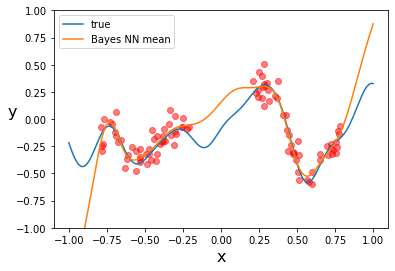

In [30]:
pb.plot(xtest,Z,label='true')
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean')
pb.scatter(x,y,c='r',alpha=0.5)
pb.legend()
pb.ylim([-1,1])
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
#pb.savefig("BayesNN_mean.pdf")

We now plot the uncertainty, by plotting 700 nonlinear regression lines from the posterior

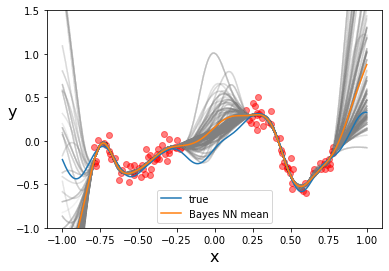

In [31]:
#y_es=posterior['act_out'].mean(axis=0)
pb.plot(xtest,Z,label='true',Zorder=100)
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean',Zorder=100)
for i in range(700):
    pb.plot(xtest,ypred[i,:],c='gray',alpha=0.05)
pb.scatter(x,y,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.ylim([-1,1.5])
pb.legend()
#pb.savefig("BayesNN_samples.pdf")

We can plot the 99% credible interval for a better representation.

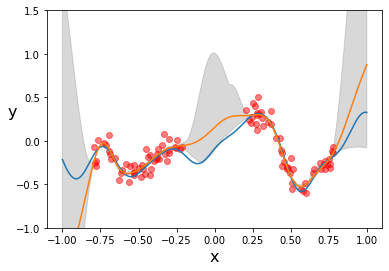

In [32]:
#y_es=posterior['act_out'].mean(axis=0)
pb.plot(xtest,Z,label='true',Zorder=100)
pb.plot(xtest,ypred.mean(axis=0),label='Bayes NN mean',Zorder=100)
sig = pm.hpd(ypred, credible_interval=0.99)
pb.fill_between(xtest, sig[:,0], sig[:,1], color='gray',alpha=0.3)
pb.scatter(x,y,c='r',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.ylim([-1,1.5])
pb.savefig("BayesNN_hpd.pdf")

Note that Bayesian NN correctly tells us that our prediction in the regions far from the data is more uncertain
and, therefore, it tells us we should not trust it as much as we trust it in the region where we have data. 

This confirms again why Bayesian learning is better than standard loss-function minimization. Of course, computing the posterior is more computationally demanding as you noticed.